In [1]:
from ASGCNN.Model import ASGCNN_pretrain
from ASGCNN.Trainer import Trainer
from ASGCNN.Encoder import Graph_data_loader, Encoder_element

import dgl
import zipfile
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from pymatgen.core import Element
from pymatgen.core import Structure
from pymatgen.analysis.adsorption import plot_slab

# ASGCNN
The **adsorbate-site graph convolutional neural network** ([**ASGCNN**](https://www.sciencedirect.com/science/article/pii/S0169433224012327)) has the following architecture. It uses **unrelaxed adsorption  slab** structure as input. A **slab graph** and an **adsorbate-site graph** are then created. Features in these two graphs are convolved and aggregated to predict the **adsorption (free) energy** as well as **categories of adsorbate and adsorption site class**.
![architecture](architecture.png)

# Load pre-prepared dataset
Load pre-prepared dataset using **Graph_data_loader**

Three parameters are needed for the creation of **Graph_data_loader**:
- a **csv file** that records the target values
- a **xx.bin** file that stores graph data (saved by dgl package)
- a **list of strings** of column names for the target values in the sequence of adsorbate category, site category and adsorption energy

Here, we load the dataset used in literature with 6,000 Heusler alloy adsorption energy data points, which were split into training, validation, and test sets in a ratio of 5000: 500: 500.   

Due to the file size limit, we need to extract part of the bin file first

In [2]:
with zipfile.ZipFile(r'data/Graph_adsb_train.zip', 'r') as zip_ref:
    zip_ref.extract('Graph_adsb_train.bin', 'data')
    
with zipfile.ZipFile(r'data/Graph_slab_train.zip', 'r') as zip_ref:
    zip_ref.extract('Graph_slab_train.bin', 'data')

Now, we can create **Graph_data_loader** and load data to it.

In [3]:
# list of target column names
target = ['Cadsb', 'Csite', 'Gads']

# load training set
train_excel =  'data/Train_data_5000.csv'
Encoders_train = ['data/Graph_adsb_train.bin', 'data/Graph_slab_train.bin']
Loader_train = Graph_data_loader() # 256 is the specified batch size for Loader_train here
Loader_train.load_data(train_excel, Encoders_train, target=target)

# load validation set
valid_excel = 'data/Valid_data_500.csv'
Encoders_valid = ['data/Graph_adsb_valid.bin', 'data/Graph_slab_valid.bin']
Loader_valid = Graph_data_loader()
Loader_valid.load_data(valid_excel, Encoders_valid, target=target)

# load test set
test_excel = 'data/Test_data_500.csv'
Encoders_test = ['data/Graph_adsb_test.bin', 'data/Graph_slab_test.bin']
Loader_test = Graph_data_loader()
Loader_test.load_data(test_excel, Encoders_test, target=target)

# Graph data
Let's look at the dataset, check out the first data at training set. According to the csv file, it is **Pt2CuIn_NH_0_1h**, an NH molecular adsorbate at 3 hollow site of Pt2CuIn. This **scaled slab** structure of this data sample can be found at 'structures/All_unrelaxed_adsorption_structure_2layer_fix_lattice.rar'. We took it out in advance

In [4]:
df = pd.read_csv(train_excel, index_col=0)
df[: 1]

,adss,Gads,adsb,slab,bulk,Csite,Cadsb
0,Pt2CuIn_NH_0_1h,0.523165,Pt2CuIn_NH_0_1h,Pt2CuIn_NH_0_1h,Pt2CuIn,2,2


<Axes: >

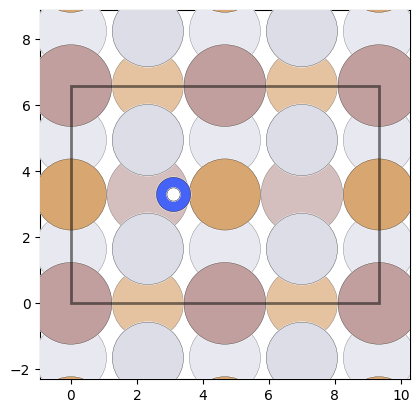

In [5]:
scaled_slab = Structure.from_file(r'data\example\structure\Pt2CuIn_NH_0_1h.vasp')
fig, ax = plt.subplots()
plot_slab(ax=ax, slab=scaled_slab, repeat=3, window=0.6, adsorption_sites=False, decay=0.1)

It is NH adsorb at Pt-Pt-Cu hollow site. Now, let us check out its graph data.  

Graphs are stored in the **.graphs** attribute of the **Graph_data_loader**. The **.graphs** attribute is a list with a shape of (*number of graph types*, *number of graphs*). For example, the **Loader_train** has two types of graphs (adsorbate-site graph and slab graph), so its shape will be (2, 5000). To access the first slab graph, you should:

In [6]:
g = Loader_train.graphs[1][0]
g

Graph(num_nodes=18, num_edges=168,
      ndata_schemes={'symbol': Scheme(shape=(), dtype=torch.int32), 'h_v': Scheme(shape=(101,), dtype=torch.float32)}
      edata_schemes={'radius': Scheme(shape=(), dtype=torch.float32), 'h_e': Scheme(shape=(8,), dtype=torch.float32)})

In [7]:
g.ndata['symbol']

tensor([49, 49, 49, 49, 29, 29, 29, 29,  1, 78, 78, 78, 78, 78, 78, 78, 78,  7],
       device='cuda:0', dtype=torch.int32)

Let us check the first adsorbate-site graph and slab graph in the training set. They are clearly NH adsorbate adsorbs on Pt-Pt-Cu hollow site corresponding to the VASP structure .

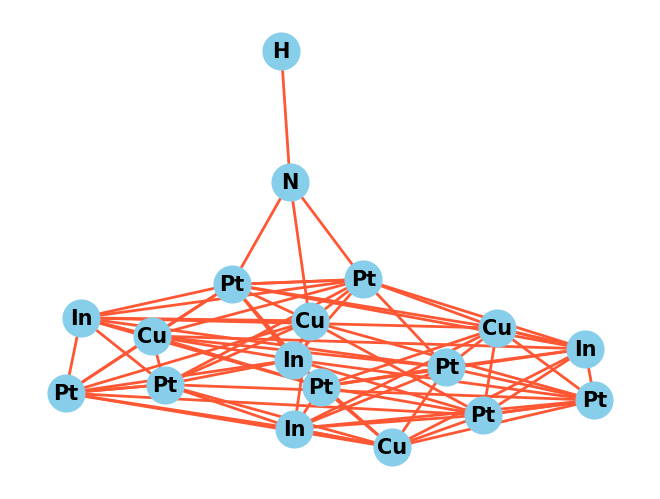

In [8]:
# slab graph
g = Loader_train.graphs[1][0]
nx_g = g.cpu().to_networkx().to_undirected()
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, labels={i: Element.from_Z(g.ndata['symbol'][i].item()).symbol for i in range(g.number_of_nodes())},
        node_color='skyblue', edge_color='#FF5733', node_size=700, font_size=15, font_weight='bold', width=2)

plt.show()

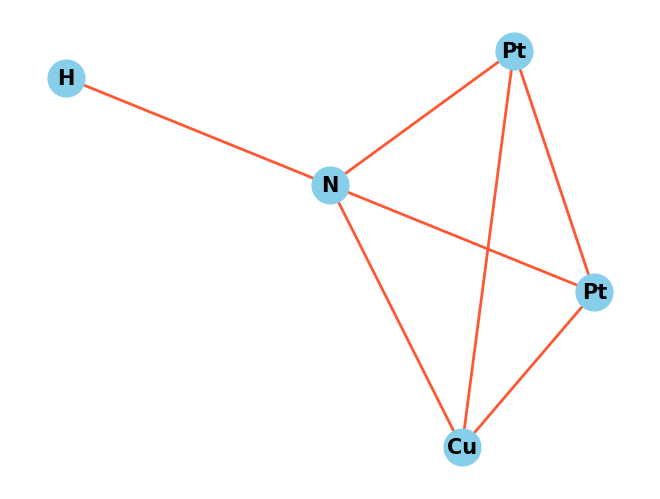

In [9]:
# adsorbate-site graph
g = Loader_train.graphs[0][0]
nx_g = g.cpu().to_networkx().to_undirected()
pos = nx.spring_layout(nx_g)
nx.draw(nx_g, pos, with_labels=True, labels={i: Element.from_Z(g.ndata['symbol'][i].item()).symbol for i in range(g.number_of_nodes())},
        node_color='skyblue', edge_color='#FF5733', node_size=700, font_size=15, font_weight='bold', width=2)

plt.show()

# Node feature

Let's take a look at the node features in the graph. The first node is **In**, which is characterized by one-hot encoding

In [10]:
g.ndata['symbol'][0]

tensor(29, device='cuda:0', dtype=torch.int32)

In [11]:
g.ndata['h_v'][0]

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')

Features in the literature can be reproduced in the following ways

In [12]:
Ee = Encoder_element(
    features=['radius','weight','volume','electronegativity','affinity','ionization','Zeff','group','period','d-electron'])

In [13]:
Ee.feature_lentgh_total

101

Now look at the node feature of **In** given by the **Encoder_element**, which are consistent with those in the graph data

In [14]:
Ee['In']

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

The value of each specific feature can be disassembled as

In [15]:
Ee.decode_element('In')

radius  :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
weight  :  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
volume  :  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
electronegativity  :  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
affinity  :  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ionization  :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Zeff  :  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
group  :  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
period  :  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
d-electron  :  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Load pre-trained models
The pre-trained models can be loaded by **load_pretrained** on **Trainer**. Due to version updates, you need to use **ASGCNN_pretrain**

Define the **ASGCNN_pretrain** model. Pass the model and data loaders together into a **Trainer** and use **.load_pretrained** to load pretrained models.   

In [16]:
# define a model with pre-adjusted hyperparameters 
model = ASGCNN_pretrain()

# create Trainer
t=Trainer(model, Loader_train, Loader_valid, Loader_test, target_dims=[5, 4, 1])

# load pre-trained models
t.load_pretrained(location='cuda')

Now, we can get the same parity plot and metrics as in the paper.

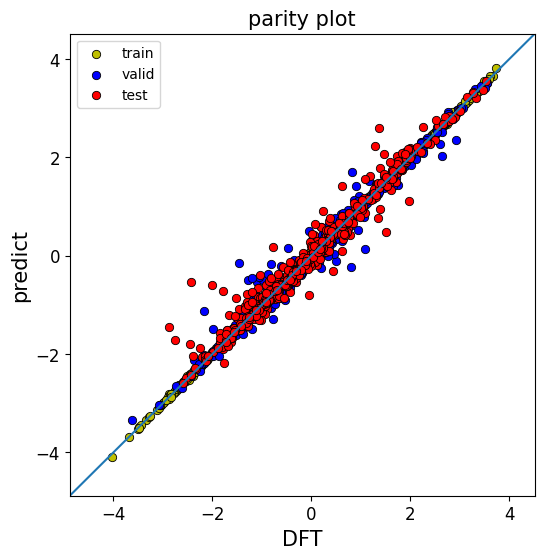

In [17]:
t.show_result(ti=2)

In [18]:
t.calculate_static()

{'train': {'f1_0': 1.0,
  'ac_0': 1.0,
  'pc_0': 1.0,
  'rc_0': 1.0,
  'f1_1': 1.0,
  'ac_1': 1.0,
  'pc_1': 1.0,
  'rc_1': 1.0,
  'r2_2': 0.9997970082687139,
  'mae_2': 0.012860747,
  'mse_2': 0.00029508304,
  'rmse_2': 0.01717798},
 'valid': {'f1_0': 1.0,
  'ac_0': 1.0,
  'pc_0': 1.0,
  'rc_0': 1.0,
  'f1_1': 1.0,
  'ac_1': 1.0,
  'pc_1': 1.0,
  'rc_1': 1.0,
  'r2_2': 0.9770201983410584,
  'mae_2': 0.10485717,
  'mse_2': 0.03427182,
  'rmse_2': 0.1851265},
 'test': {'f1_0': 1.0,
  'ac_0': 1.0,
  'pc_0': 1.0,
  'rc_0': 1.0,
  'f1_1': 1.0,
  'ac_1': 1.0,
  'pc_1': 1.0,
  'rc_1': 1.0,
  'r2_2': 0.9608974995816346,
  'mae_2': 0.13154131,
  'mse_2': 0.05850531,
  'rmse_2': 0.24187872}}

# Make prediction
Finally, we show how to make a prediction.  

If you want to use pre-trained models to make predictions, load your data into a **Graph_data_loader** and pass it into the prediction function.

In [19]:
predict, uq = t.predict(Loader_test, to_class=True, return_uq=True)

In [20]:
Loader_test.target[:3]

tensor([[ 0.0000,  0.0000, -0.5184],
        [ 3.0000,  0.0000, -1.3138],
        [ 2.0000,  3.0000, -2.3946]], device='cuda:0')

In [21]:
predict[:3]

array([[ 0.       ,  0.       , -0.5254885],
       [ 3.       ,  0.       , -1.3168112],
       [ 2.       ,  3.       , -2.0372057]])

In [22]:
uq[:3]

array([[0.02289954],
       [0.03610377],
       [0.03876781]], dtype=float32)